### 1. 加载库
### 2. 定义一个方法，显示图片
### 3. 定义超参数
### 4. 图片转换
### 5. 操作数据集

In [1]:
conda deactive d2l-zh

usage: conda [-h] [-v] [--no-plugins] [-V] COMMAND ...
conda: error: argument COMMAND: invalid choice: 'deactive' (choose from 'activate', 'deactivate', 'clean', 'compare', 'config', 'create', 'env', 'export', 'info', 'init', 'install', 'list', 'notices', 'package', 'remove', 'uninstall', 'rename', 'run', 'search', 'update', 'upgrade', 'build', 'content-trust', 'convert', 'debug', 'develop', 'doctor', 'index', 'inspect', 'metapackage', 'render', 'repoquery', 'skeleton', 'server', 'token', 'verify', 'pack', 'repo')

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda activate base


CondaError: Run 'conda init' before 'conda activate'


Note: you may need to restart the kernel to use updated packages.


In [9]:
# 1. 加载库
import torch
import torch.nn as nn
from torchvision import datasets, transforms,models
import os
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# 2. 定义一个方法，显示图片
def image_show(inp, title=None):
#     plt.figure(figsize=(14,3))
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp +mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()


def main():
    # 3 定义超参数
    BATCH_SIZE = 8 # 每批处理的数据数量
    DEVICE = torch.device("mps")
    
    # 4.1 构建pipeline, 对图像做处理
    pipeline = transforms.Compose([
        transforms.Resize(300), # 图片缩小到300
        transforms.RandomResizedCrop(300),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(256), # 中心裁剪
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225]), # 对图片进行正则化
    ])

    # 4.2 图片转换
    data_transforms = {
        "train": transforms.Compose([
        transforms.Resize(300), # 图片缩小到300
        transforms.RandomResizedCrop(300),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(256), # 中心裁剪
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225]), # 对图片进行正则化
    ]),
        
        "val": transforms.Compose([
        transforms.Resize(300), # 图片缩小到300
        transforms.CenterCrop(256), # 中心裁剪
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225]), # 对图片进行正则化
        ])}
    # 5 操作数据集
    # 5.1 加载数据集
    dataset = "/Users/leon/LeonProject/scientificProject/dataset/chest_xray"
    # 5.2 加载数据集train 和 val
    image_datasets = {x:datasets.ImageFolder(os.path.join(dataset, x), data_transforms[x]) for x in ['train','val']}
    # 5.3 给数据集创建一个迭代器，读取数据
    data_loader = {x : DataLoader(image_datasets[x], shuffle=True, batch_size=BATCH_SIZE) for x in ['train', 'val']}
    
    # 5.4 训练和验证集的大小（图片的数量）
    data_size = {x: len(image_datasets[x]) for x in ['train', 'val']}
    
    # 5.5 获取标签类别的名称: NORMAL 正常， PNEUMONIA 感染
    target_names = image_datasets['train'].classes
    
    # 6 显示一个batch_size的图片（8张图片）
    # 6.1 读取8张图片
    datas, targets = next(iter(data_loader['train']))
    # 6.2 将若干张图片拼成一幅图像
    out = make_grid(datas, nrow=4, padding=10)
    # 6.3 显示图片
    image_show(out, title = [target_names[x] for x in targets])


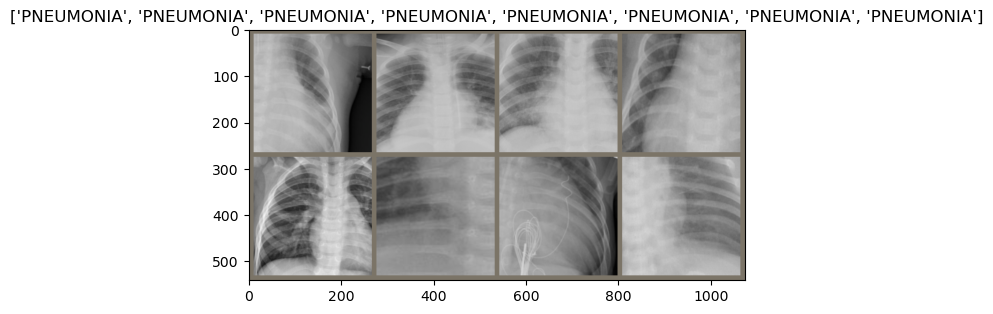

In [8]:
main()

In [10]:
# 7 迁移学习：拿到一个成熟的模型，进行模型微调
def get_model():
    model_pre = models.resnet50(pretrained=True) # 获取预训练模型
    # 冻结预训练模型中所有的参数
    for param in model_pre.parameters():
        param.requires_grad = False
    #微调模型：替换ResNet最后的两层网络，返回一个新的模型
    model_pre.avgpool = AdaptiveConcatPool2d() #池化层替换
    model_pre.fc = nn.Sequential(
        nn.Flatten(), #所有维度拉平
        nn.BatchNorm1d(4096), 
        nn.Dropout(0.5), # 丢掉一些神经元
        nn.Linear(4096, 512), # 线性层的处理
        nn.ReLU(), # 激活层
        nn.BatchNorm1d(512), # 正则化处理
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1), # 损失函数
    )
    return model_pre
    

# 8 更改池化层
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, size=None):
        super().__init__()
        size = size or (1,1) # 池化层的卷积核大小，默认值为（1,1）
        self.pool_one = nn.AdaptiveAvgPool2d(size) # 池化层1
        self.pool_two = nn.AdaptiveAvgPool2d(size) # 池化层2
    
    def forward(self,x):
        return torch.cat([self.pool_one(x), self.pool_two(x),1]) #连接两个池化层
    

In [ ]:
# 9 定义训练函数
def train(model, device, train_loader, criterion, optimizer, epoch, writer):
    model.train()
    total_loss = 0.0 # 总损失值初始化为0
    # 循环读取训练数据集，更新模型参数
    for batch_id, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 梯度初始化为0
        output = model(data) # 训练后的输出
        loss = criterion(output,target) # 计算损失
        loss.backward() # 反向传播
        optimizer.step() # 更新参数
        total_loss += loss # 累计训练损失
    
    writer.add_scalar("Train Loss", total_loss/len(train_loader), epoch)
    write.flush() # 刷新
    return total_loss / len(train_loader) # 返回平均损失值

# 10 定义测试函数
def test(model, device, test_loader, criterion, epoch, writer):
    model_eval()
    # 损失和正确
    total_loss = 0.0
    correct = 0.0
    # 循环读取数据
    with torch.no_grad():
        for data, target in test_loader:
            data , target = data.to(device), target.to(device)
            # 预没输出
            output = model(data)
            # 计算损失
            total_loss += criterion(output,target).item()
            # 获取预测结果中每行数据s概率最大的下标
            _,preds = torch.max(output,dim=1)
            # 累计预测正确的个数
            correct += torch.sum(preds==target)
        # 平均损失
        total_loss /= len(test_loader)
        # 正确率
        accuracy = correct / len(test_loader)
        # 写入日志
        writer.add_scalar("Test Loss", total_loss, epoch)
        #刷新
        writer.flush()
        # 输出信息
        print("Test Loss : {:.4f}, Accuracy : {:.4f}".format(total_loss, accuracy))
        return total_loss, accuracy